In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
# Input Parameter
sampling_rate='1S'
r=2
num_epochs = 4

In [3]:
database = pd.read_csv(r"C:\Users\Anson\OneDrive\Anson File\PythonApplication_anson\3_Kaggle\5_LRT3 Traction Power Loading\000_Network LRT3_TotalPower.csv", sep=',')
database['t_abs']=pd.to_datetime(database['t_abs'])
database.set_axis(database['t_abs'], inplace=True)
database.drop(columns=database.columns[[0,1]], axis =1, inplace=True)
database.drop(index=database.index[0], axis =0, inplace=True)
database['P_KW'] = database['P_KW'].astype(float)

# Resampling  
database= database.resample(sampling_rate).mean()


# database["P_KW"].fillna(database["P_KW"].mean(), inplace=True)
power_values_sampled= database["P_KW"]
power_values_sampled=power_values_sampled.values
date = database.index.tolist()

# print('database',database)
# print('power_values_sampled',power_values_sampled)
# print('date',date)


In [4]:
print('haha',np.isnan(power_values_sampled))
print('haha2',np.isinf(power_values_sampled))

haha [False False False ... False False False]
haha2 [False False False ... False False False]


In [5]:
# Normalization for close_data for neural network

scaler = MinMaxScaler()
# scaler = StandardScaler()
power_value_scaled = scaler.fit_transform(power_values_sampled.reshape(-1,1))

print('power_value_scaled',power_value_scaled)

power_value_scaled [[0.8437361 ]
 [0.77293076]
 [0.80224642]
 ...
 [0.88151032]
 [0.99070529]
 [0.92966126]]


In [6]:
# Divide the data for training and testing
# 80% for training data, 20% for testing data

split_percent = 0.80
split = int(split_percent*len(power_value_scaled))

In [7]:
# print('database.index',database.index.values)
# print('database.index',database.index.tolist())

In [8]:
power_value_train = power_value_scaled[:split]
power_value_test = power_value_scaled[split:]


date_train = date[:split]
date_test = date[split:]

# print('date_train \n\n',date_train)
# print('date_test \n\n',date_test)

#date_train = power_values_sampled['t_abs'][:split]
# date_test = power_values_sampled['t_abs'][split:]



In [9]:
# 5 records to take into account
look_back = int(240*r)

train_generator = TimeseriesGenerator(data=power_value_train, targets=power_value_train, length = look_back,  sampling_rate = 1, stride = 1, batch_size= 1)
test_generator = TimeseriesGenerator(data=power_value_test, targets=power_value_test, length = look_back,  sampling_rate = 1, stride = 1, batch_size= 1)


print('Samples: %d' % len(test_generator))

# for i in range(len(test_generator)):
# 	x, y = test_generator[i]
# 	print('%s => \n\n\n %s' % (x, y) ,'\n\n\n\n')



Samples: 241


In [10]:
Ns= len(train_generator)
a=10
Ni=database.shape[1]
No=database.shape[1]
n_neurons  = int(Ns/(a*(Ni+No)))


print('database',database.shape)
print('Ns',Ns)
print('n_neurons',n_neurons)


Keras_model = Sequential()
Keras_model.add(LSTM(30, activation='relu', return_sequences=True ,input_shape=(look_back, database.shape[1])))
Keras_model.add(Dropout(0.2))
Keras_model.add(LSTM(30, activation='relu', return_sequences=False ,input_shape=(look_back, database.shape[1])))
Keras_model.add(Dropout(0.2))
Keras_model.add(Dense(1))
Keras_model.compile(optimizer='adam',loss='mean_squared_error')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)


train_result=Keras_model.fit(train_generator, epochs=num_epochs ,verbose=1)



database (3602, 1)
Ns 2401
n_neurons 120
Epoch 1/4
2401/2401 [==============================] - 8316s 3s/step - batch: 1200.0000 - size: 1.0000 - loss: 0.0378
Epoch 2/4
2401/2401 [==============================] - 8298s 3s/step - batch: 1200.0000 - size: 1.0000 - loss: 0.0226
Epoch 3/4
2401/2401 [==============================] - 8301s 3s/step - batch: 1200.0000 - size: 1.0000 - loss: 0.0196
Epoch 4/4
2401/2401 [==============================] - 8352s 3s/step - batch: 1200.0000 - size: 1.0000 - loss: 0.0190


In [11]:
prediction = Keras_model.predict(test_generator)



C:\Users\Anson\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


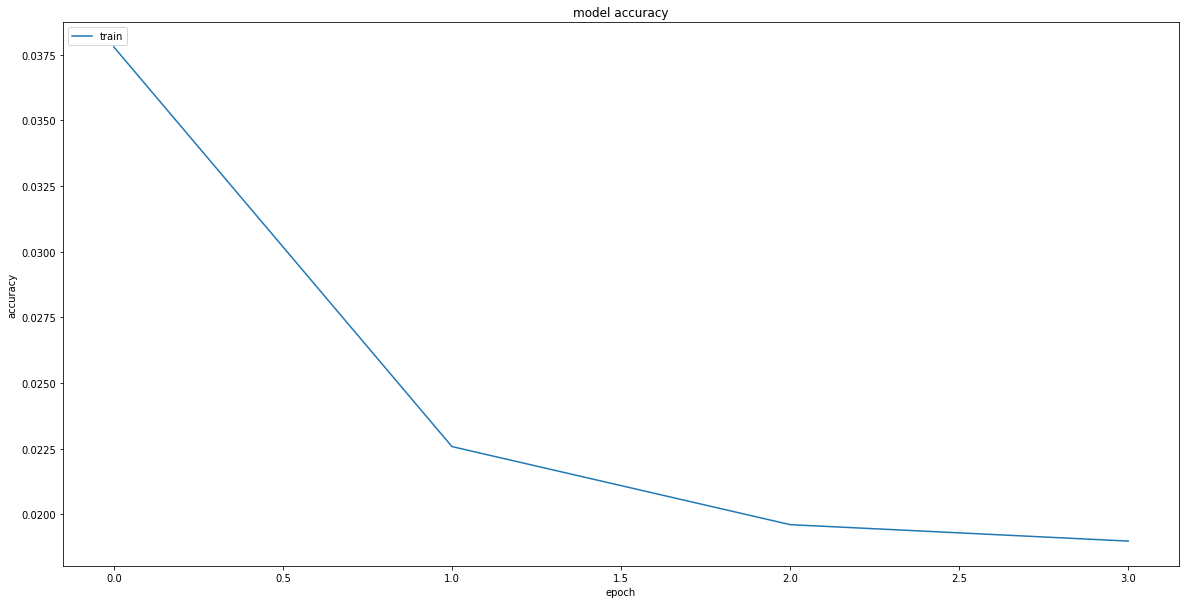

In [12]:
plt.plot(train_result.history['loss'])
# plt.plot(train_result.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
def predict_forward(num_prediction, Keras_model):
    prediction_list = power_value_scaled[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = Keras_model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)

    prediction_list = prediction_list[look_back-1:]
    return prediction_list

In [14]:
def predict_dates(num_prediction):

    last_date = date[-1]
    
    prediction_dates = pd.date_range(start=last_date, periods=num_prediction+1, freq=sampling_rate).tolist()

    return prediction_dates


In [15]:
# Prediction the Future Price

num_prediction = 5
forecast_forward = predict_forward(num_prediction, Keras_model)
forecast_dates = predict_dates(num_prediction)

In [16]:
power_train = power_value_train.reshape(-1)
power_test = power_value_test.reshape(-1)
prediction = prediction.reshape(-1)


power_train = scaler.inverse_transform(power_train.reshape(-1,1))
power_train = power_train.reshape(-1)

power_test = scaler.inverse_transform(power_test.reshape(-1,1))
power_test = power_test.reshape(-1)

prediction = scaler.inverse_transform(prediction.reshape(-1,1))
prediction = prediction.reshape(-1)


forecast_forward = scaler.inverse_transform(forecast_forward.reshape(-1,1))
forecast_forward = forecast_forward.reshape(-1)

print('forecast_forward_after_inverse transform',forecast_forward)

forecast_forward_after_inverse transform [19682.40254    15317.39110248 12245.13165193 10343.2393274
  9123.89374434  8387.65904238]


In [17]:
# print('forecast_forward',forecast_forward,)
# print('forecast_forward length',forecast_forward.shape[0])
# print('forecast_dates',forecast_dates)


In [18]:
# Graph for the stock prediction

# date_test_prediction = database.index[split+look_back:]

trace1 = go.Scatter(x = date_train, y = power_train, mode = 'lines', name = 'Ground Truth : Data Train')
trace2 = go.Scatter(x = date_test,y = power_test,mode='lines', name = 'Ground Truth : Data Test')
trace3 = go.Scatter(x = date_test[look_back:],y = prediction, mode='lines', name = 'Prediction: Data Test')
trace4 = go.Scatter(x = forecast_dates[:],y = forecast_forward, mode = 'lines', name = 'Future Forward')
layout = go.Layout(title = "Prediction of Power Consumption for LRT3 ", xaxis = {'title' : "Time"}, yaxis = {'title' : "Power KW"})
fig0 = go.Figure(data=[trace1,trace2,trace3], layout=layout)
fig = go.Figure(data=[trace1,trace2,trace3,trace4], layout=layout)
# fig = go.Figure(data=[trace1,trace2], layout=layout)
fig.show()